<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2021/blob/main/sessions/dicom-wrangling/DataWrangling2021RSNA16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RSNA2021 Hands-On Data Wrangling
Course Faculty: Katherine P. Andriole, PhD, FSIIM, 
MGH & BWH Center for Clinical Data Science, 
Brigham and Women's Hospital, 
Department of Radiology
Harvard Medical School

*(Thank you to **George Shih, MD**, Cornell Weill Medicine who coded the notebook, and to Brad Erickson, MD, PhD, Mayo Clinic; Felipe Kitamura, MD, PhD, Federal University of Sao Paulo and DASA; and Luciano Prevedello, MD, MPH, The Ohio State University Medical Center for code and concept contributions.)*

---

In this course, we will learn Data Wrangling techniques through exploration of a dataset of 30,000 chest x-rays annotated by the RSNA and the Society of Thoracic Radiology for the presence or absence of pneumonia. This dataset was used in the 2018 RSNA Machine Learning Challenge. (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge)

Performing data preprocessing and cohort analysis is a prerequiste for building machine learning models with robust and reliable results. A thorough understanding of the data cohort makeup and an assessment of data integrity, by examining the presence of missing, sparse, noisy and/or erroneous metadata is essential. We will use common machine learing libraries to assess, represent and visualize both textual and pixel data. Labeling and image annotation as well as model performance metrics will be examined.
 

 


#Preliminaries

## Create Directory Structure

Import `os` package to change a directory correctly in python.

Define `ROOT_PATH` on Google CoLab with `pneumonia` subdirectory and then change directory into that path.

In CoLab, you run bash linux commands by prefixing a command with an ! exclamation point, which is used here to create the pneumonia subdirectory.  

Within a bash command run from a notebook, you can substitute in the value of python variables using the curly brace syntax `{variable_name}` which will substitute the current contents of the variable into the command.


In [ ]:
import os
ROOT_PATH = '/content/pneumonia' # on colab you start in the path /content/
!mkdir -p {ROOT_PATH}
os.chdir(ROOT_PATH)
print(ROOT_PATH)
print ('\033[1m' + 'Cell executed. Go to next step.')

/content/pneumonia
Cell executed. Go to next step.


## Download the Data

The first command below uses `wget` to download a file from a given URL; in this case a compressed zip file from the URL to your CoLab instance.

We will use the medium dataset of 300 training images and 100 test images.


In [ ]:
#DOWNLOAD_URL = 'http://quarkonia.info/media/small_rsna_pneumonia.zip' # 12MB zip file - 60 train images; 20 test images

DOWNLOAD_URL = 'http://quarkonia.info/media/medium_rsna_pneumonia.zip' # 53MB zip file - 300 train images; 100 test images

ZIP_FILE = DOWNLOAD_URL.split('/')[-1] # split string at '/' and take last part which is file name

if not os.path.exists(ZIP_FILE): # Download if it doesn't exist
  !wget --show-progress {DOWNLOAD_URL}
else:
  print("Zip file already exists")

print("Current path:")
!pwd
print("\nCurrent directory contents:")
!ls
print ('\033[1m' + 'Cell executed. Go to next step.')

--2021-11-28 15:51:47--  http://quarkonia.info/media/medium_rsna_pneumonia.zip
Resolving quarkonia.info (quarkonia.info)... 97.107.131.153, 2600:3c03::f03c:91ff:fe96:cd66
Connecting to quarkonia.info (quarkonia.info)|97.107.131.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55513771 (53M) [application/zip]
Saving to: ‘medium_rsna_pneumonia.zip’

medium_rsna_pneumon 100%[===================>]  52.94M  64.7MB/s    in 0.8s    

2021-11-28 15:51:48 (64.7 MB/s) - ‘medium_rsna_pneumonia.zip’ saved [55513771/55513771]

Current path:
/content/pneumonia

Current directory contents:
medium_rsna_pneumonia.zip
Cell executed. Go to next step.


## OPTIONAL Use Full Data Set ---**SKIP**


The full RSNA dataset from the kaggle challenge is available at:

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

(but requires creating an account and signing up with kaggle as well as downloading 3.7 GB of compressed data instead of the smaller 52 MB sample with 300 training images).

After registering and downloading from kaggle, you can then upload to google drive by changing `use_full` from False to True with the code below.  However it will take a significant time to download and upload.

In [ ]:
use_full = False

if use_full:
  from google.colab import files
  files.upload()
  ZIP_FILE = 'rsna-pneumonia-detection-challenge.zip'
  print ('\033[1m' + 'Cell executed. Go to next step.')

##Unzip into Expected Directory Structure

This takes the zip file you've downloaded, fixes permissions (initially restrictive on the full RSNA dataset) and extracts the training images into a directory called `pneumonia/train`

In [ ]:
if not os.path.exists('train/'):
  !unzip {ZIP_FILE}
  !chmod 664 *.zip *.csv
  os.mkdir('train/')
  !unzip -q stage_2_train_images.zip -d train/
  print ('\033[1m' + 'Cell executed. Go to next step.')
else:
  print("Already unzipped.")
  print ('\033[1m' + 'Cell executed. Go to next step.')

Archive:  medium_rsna_pneumonia.zip
  inflating: stage_2_detailed_class_info.csv  
  inflating: stage_2_train_labels.csv  
 extracting: stage_2_test_images.zip  
 extracting: stage_2_train_images.zip  
  inflating: extras/dcm_train_metadata_full.csv  
  inflating: extras/dcm_test_metadata_full.csv  
  inflating: stage_2_sample_submission.csv  
 extracting: GCP Credits Request Link - RSNA.txt  
Cell executed. Go to next step.


# Common Libraries Used for Data Wrangling and Machine Learning

* `os` is a built-in python library for exploring the file system.
* [pandas](https://pandas.pydata.org/) is a library for reading and processing tabular data.
* [numpy](https://www.numpy.org/) is a library for fast numerical operations on arrays of numerical data
* [matplotlib](https://matplotlib.org/) is a plotting library
* [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) is a library for opening and loading dicom images
* [seaborn](https://seaborn.pydata.org/) is a plotting library built on top of matplotlib with a higher level interface with better defaults for data visualization ([seaborn tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial))

## Install Libraries Not Installed by Default in Google CoLab

The packages pandas, numpy and matplotlib are installed by default in Google CoLab. However pydicom is not automatically included so we have to go to the command line and install using `pip` (the python package installer). Try to import the module (if it exists). If it doesn't exist we get an `ImportError`. Use `pip` to install the package in CoLab.

In [ ]:
!pip install pydicom
print ('\033[1m' + 'Cell executed. Go to next step.')

     |████████████████████████████████| 2.0 MB 5.3 MB/s 
Cell executed. Go to next step.


# Basic Import Statements to Load Common Libraries into Python
To import a module into python, it is simply `import module` and you can access functions (or submodules, classes, variables, etc.) belonging to the module via `module.name_of_thing_in_module`.  For importing `pandas`, `numpy`, `matplotlib.pyplot` it is convenient to import using common abbreviations.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dcm

import warnings
warnings.filterwarnings('ignore') # done to silence a seaborn deprecation warning
print ('\033[1m' + 'Cell executed. Go to next step.')


Cell executed. Go to next step.


# Explore the Spreadsheet Data

## Open the data into panda DataFrames

There are two .csv files associated with the RSNA pneumonia challenge that we will load into pandas DataFrames: the bounding box DataFrame (bbox) and the class DataFrame (class)

A pandas **DataFrame** is a collection of tabular data, similar to a spreadsheet. It is the primary data structure for pandas.

Since we have the tabular data loaded into .csv spreadsheets, we will use `pd.read_csv(file_name)` to read the data into    DataFrames.

In [ ]:
bbox_df = pd.read_csv('stage_2_train_labels.csv')         # CSV of labeled bounding box information
class_df = pd.read_csv('stage_2_detailed_class_info.csv') # CSV with extra detailed_class_info
print ('\033[1m' + 'Cell executed. Go to next step.')

Cell executed. Go to next step.


### Printing the Last Value Returned in a Jupyter Notebook Codeblock

You can insert multiple lines of python code inside a Jupyter codeblock.

If the last python line in a code block returns a value, it will be displayed and formatted below the codeblock.  (When you assign a value to a variable, python will NOT return a value.) 

Thus a common pattern in codeblocks is to calculate a DataFrame, assign it to something, and then repeat the last calculated value to display it.

### Print Out the Contents of the bbox DataFrame

In [ ]:
df = bbox_df.copy() # create a copy of bbox_df
df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


## View Samples of the .csv Data Files in the "bbox" and "class" DataFrames

`df.head(n)` is a useful function to look at the first n rows of a DataFrame to get a feel for the DataFrame.

`df.tail(n)` acts similarly looking at the last n rows of the DataFrame

`df.sample(n)` looks at n randomly selected entries.  

If unspecified n defaults to 5, for the functions above

### Data Field Descriptions from [RSNA pneumonia dataset](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data):

* `patientId`- A patient Id. Each patient Id corresponds to a unique image.
* `x` - the upper-left x coordinate of the bounding box.
* `y` - the upper-left y coordinate of the bounding box.
* `width` - the width of the bounding box.
* `height` - the height of the bounding box.
* `Target` - the binary Target, indicating whether this sample has evidence of pneumonia.

Print the first 5 rows of "bbox".


In [ ]:
bbox_df.head() # Note it defaults to N=5

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Print the last 10 rows of "class".

In [ ]:
class_df.tail(10)

,patientId,class
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,No Lung Opacity / Not Normal
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,Normal
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


Print 20 random samples of "bbox".

In [ ]:
bbox_df.sample(20)

,patientId,x,y,width,height,Target
508,082fd63e-aec4-401a-822b-eb10d98b562c,153.0,312.0,266.0,526.0,1
11265,757438a0-081e-45e5-9896-ba91f82d3055,750.0,534.0,126.0,245.0,1
15269,9575f8d4-6d15-448e-a615-da0d60c2a961,NaN,NaN,NaN,NaN,0
8612,60d3e1bc-5e25-40b6-bd12-ddbd2a3df8f4,NaN,NaN,NaN,NaN,0
6227,4d49d9a9-ce3d-4a0d-81a8-667552d64163,NaN,NaN,NaN,NaN,0
29548,1c9d6056-3f6e-4d56-b425-e216ead4038b,NaN,NaN,NaN,NaN,0
26994,f02e36df-ac4d-43f1-8001-3e0494145b0a,121.0,194.0,228.0,454.0,1
3095,361c09b7-beb1-4be9-bb4b-c6400c293a19,179.0,324.0,246.0,512.0,1
4300,3dfbfdd9-ac6b-4862-96ef-a0a90378d43a,NaN,NaN,NaN,NaN,0
16524,9fb3a24b-206e-4d21-92e5-7818fac9105a,NaN,NaN,NaN,NaN,0


## Describe the Dataset

`df.shape` returns the shape of the DataFrame.  Note this is a property of the DataFrame, not a function (hence no parentheses)
`df.describe()` shows summary statistics about a DataFrame. 

For object (categorical/string/timestamp) data, it shows:

* the **count** of each column, 
* the number of **unique** entries, 
* the **top** (most frequent) entry
* the **freq**uency of the top entry (number of occurrences)

For numerical data, it shows the **count**, **mean** (average), **std** (standard deviation), **min**imum, **25%** percentile, **50%** percentile (median), **75%** percentile, and **max**imum.

If both categorical data and numerical data columns are present, by default `df.describe()` will only describe the numerical columns.  However, you can show both with `df.describe(include='all')`.

#### Show the Dimensions of "bbox" and "class" DataFrames, then show the total number of entries, the number of unique entries, the most frequent entry, and it's number of occurrences.

In [ ]:
print("BBox Shape:", bbox_df.shape)
print("Class info Shape:", class_df.shape)

BBox Shape: (30227, 6)
Class info Shape: (30227, 2)


# **EXAMINE THESE CHART RESULTS**

In [ ]:

class_df.describe(include='all') 


,patientId,class
count,30227,30227
unique,26684,3
top,ee820aa5-4804-4984-97b3-f0a71d69702f,No Lung Opacity / Not Normal
freq,4,11821


## Pandas Slicing

You can select a column from a pandas DataFrame using either syntax below:

`df['column_name']` or `df.column_name`

which returns a pandas Series (an indexed array of data values) contained in that column of data.  The first method will always work regardless of column name, but the second syntax can only be used when there are no spaces or other special characters in the column name and the name doesn't otherwise clash (e.g., isn't a member function of a pandas dataFrame).

You can then compare this array element by element with standard comparison operators; e.g., using Boolean operators the following will be set to True when the row has a Target of 0 and False otherwise.


In [ ]:
bbox_df.Target == 0 # Returns pandas.Series filled with True when the row has a Target of 0, False otherwise.

0         True
1         True
2         True
3         True
4        False
         ...  
30222    False
30223     True
30224     True
30225    False
30226    False
Name: Target, Length: 30227, dtype: bool

##### Python's `any` and `all` Operators

In [ ]:
# Python comes with built-in operators that allow you to test `any` or `all` elements in a iterable way as follows, 
#with the result converted to Booleans True or False 

any([False, True, False]) # returns True when at least one value is True; this example returns "True"
all([False, True, True])  # returns True only when all values are True; this example returns "False"

# Aside: python's any and all functions will attempt to cast values to Booleans before testing them.
# In python types that translate to being empty or zero when cast to a Boolean are False (they are "Falsy")
# (e.g., "", 0, None, [], {}, etc)
# Non-empty containers and non-zero valued numbers things are "Truthy" and bool(non_empty_non_zero_value) == True

any([False, "", 0, None, [], {}]) # returns False - False, "", 0, None, [], {} are all considered Falsy types in python
all([True, "Hello", 1]) # returns True; in python non-empty strings, non-zero numbers when cast to Boolean evaluate to True

True

#Demonstrate that the 'patientId' column is the same in both the "bbox" and "class" DataFrames when compared row-by-row.

In [ ]:
all(bbox_df['patientId'] == class_df['patientId'])

True

## Boolean Array Indexing

You can then use this True/False pandas.Series to index your DataFrame and only select rows where the entry in the Series is True.

`df[df.Target == 0]` # picks out rows from `df` where the value of `Target` column is `0`.

We can then verify the non-null count using the function `df.count()` which returns the number of rows where each column is non-null.

Note this type of slicing (Boolean Array Indexing) is not only used for selecting slices of a DataFrame, but can also be used for updating slices of a DataFrame.



In [ ]:
bbox_df[bbox_df.Target == 0] # This selects all rows of bbox_df with Target==0

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


# **EXAMINE THESE CHART RESULTS**

In [ ]:

bbox_df[bbox_df.Target == 0].count() #This counts all rows of bbox_df with Target==0.

patientId    20672
x                0
y                0
width            0
height           0
Target       20672
dtype: int64

## Adding a Column to a DataFrame

The syntax for adding a column to a DataFrame is straightforward; you just create a new column name and assign to it a Series of the correct size.  

For example, if you want to add a column called "Area" to the "bbox" DataFrame where Area is the product of `bbox_df.width` x `bbox_df.height`, use the command below

In [ ]:
bbox_df['area'] = bbox_df.width * bbox_df.height
bbox_df

,patientId,x,y,width,height,Target,area
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,80727.0
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,86412.0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,NaN
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,NaN
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,90045.0


If we don't want the column, we can delete that column using the `del` keyword and using the following indexing notation to select the column we want to remove.

Obviously if we run the following cell twice, we'll raise a `KeyError` when trying to delete a column that no longer exists.


In [ ]:
del bbox_df['area']
bbox_df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


##Merge DataFrames
It can be helpful to merge DataFrames. First, we have to be certain that the row index, 'patientId' columns in our example, is identically sized and there is a one-to-one correspondance between rows across the "bbox" and "class" DataFrames -- which we did above.


Now we can merge the DataFrames by simply copying new columns into our DataFrame, for example, the (patID) and (class) columns from `class_df`:


In [ ]:
bbox_df['patId_from_class'] = class_df['patientId']
bbox_df['class'] = class_df['class']
bbox_df

,patientId,x,y,width,height,Target,patId_from_class,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [ ]:
# After again verifying that 'patId_from_class' matches 'patientId', we can delete the duplicate column
if all(bbox_df['patId_from_class'] == bbox_df['patientId']):
  del bbox_df['patId_from_class']
  
bbox_df

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity


But we are going to merge in a more generic way where we don't require that the patientId column between the two DataFrames to merge are identical. So let's delete the 'class' column

In [ ]:
del bbox_df['class']
bbox_df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


###Using merge to join DataFrame akin to SQL JOIN

We can take two distinct DataFrames in pandas and merge them into one concatenated DataFrame, similar to a [SQL JOIN](https://i.stack.imgur.com/VQ5XP.png).

In `left_df.merge(right_df, on='patientId', how='inner')`

the parameter `on` determines the column we merge on and `how` specifies whether we do an

`inner`: INNER join (use intersection of keys),
`left`: LEFT OUTER join (always keep left key)
`right`: RIGHT OUTER join (always keep right key)
`outer`: OUTER join (use union of two keys)

Note because `stage2_detailed_class_info.csv` has one row for every bounding box (with the same label for all bounding boxes corresponding to the same patient), we should first remove duplicate rows before doing a JOIN type merge with `df.drop_duplicates()`.

If we do not remove duplicates before joining we'll find that doing a naive inner JOIN on patientId when there are say three bounding boxes on a patient image they'll be three rows in `bbox_df` and three corresponding rows in `class_df`. The JOIN would then calculate the inner product where the patient_id match and after the JOIN we would have 9 rows (instead of 3) for our merged df.

Create a DataFrame with no repeated rows with the information in class_df to remove repeated rows.

Do a merge between bbox_df and class_df with no duplicates.  Call this merged DataFrame `df`

Inspect the merged DataFrame

In [ ]:
class_df_no_dups = class_df.drop_duplicates()
df = bbox_df.merge(class_df_no_dups, on='patientId', how='inner')
df.head(8)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [ ]:
df.describe(include='all') # show numerical and string data

,patientId,x,y,width,height,Target,class
count,30227,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227
unique,26684,NaN,NaN,NaN,NaN,NaN,3
top,ee820aa5-4804-4984-97b3-f0a71d69702f,NaN,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
freq,4,NaN,NaN,NaN,NaN,NaN,11821
mean,NaN,394.047724,366.839560,218.471376,329.269702,0.316108,NaN
std,NaN,204.574172,148.940488,59.289475,157.750755,0.464963,NaN
min,NaN,2.000000,2.000000,40.000000,45.000000,0.000000,NaN
25%,NaN,207.000000,249.000000,177.000000,203.000000,0.000000,NaN
50%,NaN,324.000000,365.000000,217.000000,298.000000,0.000000,NaN
75%,NaN,594.000000,478.500000,259.000000,438.000000,1.000000,NaN


## View Distribution of Data with Histograms

`df.hist()` specifies a histogram showing the distribution of values of each column of numerical data.  Note these plots are generated from pandas by internally calling matplotlib.


EXAMINE THESE HISTOGRAMS


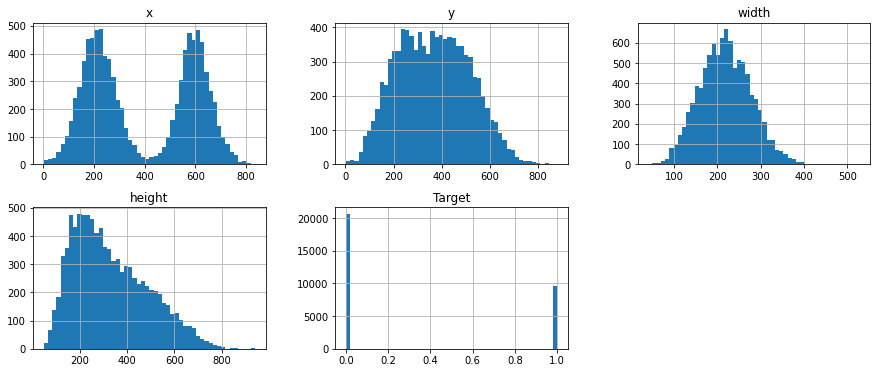

In [ ]:
print ('\033[1m' + 'EXAMINE THESE HISTOGRAMS')
hist = df.hist(bins=50, layout=(2,3), figsize=(15,6))

## Inspect Missing Data

Define the function below to inspect the missing data.
 
 `df.isnull()` return `False` (0) if a cell is non-empty or `True` (1) when a cell is null (or `NaN`).
 
 `df.isnull().sum()` then counts the number of null rows in every column of `df` (note in python `True+True==2`)
 
 `df.index` returns the index of row labels that can quickly be counted to specify number of rows using `len(df.index)`
 
 `pd.concat` concatenates pandas Series (a column of pandas data) along an axis and appends appropriate labels.

In [ ]:
def missing_data(df):
  null_data = df.isnull().sum()
  num_rows = len(df.index)
  percent_null = 100.*null_data/num_rows
  return pd.concat([null_data, percent_null.round(1)], axis=1, keys=['Missing', 'PercentMissing'])

missing_data(df)

,Missing,PercentMissing
patientId,0,0.0
x,20672,68.4
y,20672,68.4
width,20672,68.4
height,20672,68.4
Target,0,0.0
class,0,0.0


####Compare the count of missing data to the value of the Target column; see how many rows have Target == 0 and how many rows have Target == 1.

In [ ]:
print("Target 0")
print("="*20)
print(df[df.Target == 0].count())
print("")
print("Target 1")
print("="*20)
print(df[df.Target == 1].count())

Target 0
patientId    20672
x                0
y                0
width            0
height           0
Target       20672
class        20672
dtype: int64

Target 1
patientId    9555
x            9555
y            9555
width        9555
height       9555
Target       9555
class        9555
dtype: int64


Conclusion: bounding box is only defined for Target = 1; otherwise x, y, width, height are null (which makes sense with missing data above).
#EXAMINE THESE COUNTS MORE CLOSELY

## Distribution of Counts in our Dataset

`series.value_counts()` takes a pandas series and returns the number of counts of each unique value in that series, and by default sorts the unique labels by count in descending order.

In [ ]:
df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

### Express as a percentage for each class category.

In [ ]:
df['class'].value_counts()*(100.0)/len(df.index)

No Lung Opacity / Not Normal    39.107421
Lung Opacity                    31.610812
Normal                          29.281768
Name: class, dtype: float64

#### Verify that Target == 1 has only one Class (Lung Opacity). Another way to do this and verify the numbers is to examine Class == 'Lung Opacity'.

In [ ]:
df[df.Target==1].describe(include='all') # Note we selected on Target = 1 and show only one unique value of class, the top value seen is "Lung Opacity"

,patientId,x,y,width,height,Target,class
count,9555,9555.000000,9555.000000,9555.000000,9555.000000,9555.0,9555
unique,6012,NaN,NaN,NaN,NaN,NaN,1
top,76f71a93-8105-4c79-a010-0cfa86f0061a,NaN,NaN,NaN,NaN,NaN,Lung Opacity
freq,4,NaN,NaN,NaN,NaN,NaN,9555
mean,NaN,394.047724,366.839560,218.471376,329.269702,1.0,NaN
std,NaN,204.574172,148.940488,59.289475,157.750755,0.0,NaN
min,NaN,2.000000,2.000000,40.000000,45.000000,1.0,NaN
25%,NaN,207.000000,249.000000,177.000000,203.000000,1.0,NaN
50%,NaN,324.000000,365.000000,217.000000,298.000000,1.0,NaN
75%,NaN,594.000000,478.500000,259.000000,438.000000,1.0,NaN


In [ ]:
df[df['class'] == 'Lung Opacity'].describe(include='all') # Looking at it the other way, we selected on Class and saw the numerical value Target appear 9555 times as 1.0 (as seen with a max and min value of 1.0)

,patientId,x,y,width,height,Target,class
count,9555,9555.000000,9555.000000,9555.000000,9555.000000,9555.0,9555
unique,6012,NaN,NaN,NaN,NaN,NaN,1
top,76f71a93-8105-4c79-a010-0cfa86f0061a,NaN,NaN,NaN,NaN,NaN,Lung Opacity
freq,4,NaN,NaN,NaN,NaN,NaN,9555
mean,NaN,394.047724,366.839560,218.471376,329.269702,1.0,NaN
std,NaN,204.574172,148.940488,59.289475,157.750755,0.0,NaN
min,NaN,2.000000,2.000000,40.000000,45.000000,1.0,NaN
25%,NaN,207.000000,249.000000,177.000000,203.000000,1.0,NaN
50%,NaN,324.000000,365.000000,217.000000,298.000000,1.0,NaN
75%,NaN,594.000000,478.500000,259.000000,438.000000,1.0,NaN


## Generate a Countplot of this Series

`sns.countplot(series)` creates a bar graph of the number of distinct values present in the pandas series. 

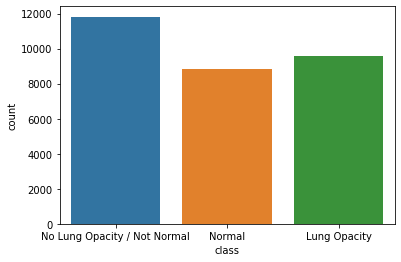

In [ ]:
countplot = sns.countplot(df['class'])

### Grouping the Categories

Do another `countplot` where we first plot the x-axis by `Target` value but break up each group of `Target` value into each `class` using the `hue` keyword.  In this type of plot there are groups of colored bars (colored based on the column indicated by 'hue')


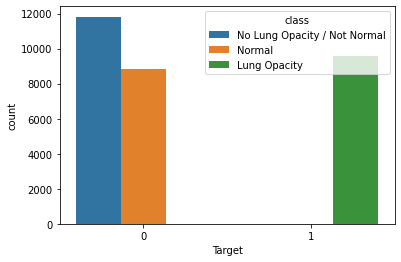

In [ ]:
target_class_plot = sns.countplot(data=df, x='Target', hue='class')

# Exploring DICOM Data

Examine the DICOM data in the training set (300 cases) located in subdirectory `train/`.

Only a sample of the images is loaded, so let's browse the directory to see which files are present.



```os.listdir() ``` is a useful function that takes in a string and gives back a python list of the contents of the directory associated with that string.



#### Get a list of the Training Images and Count the Number


In [ ]:
image_file_names = os.listdir('train/')
print(image_file_names[0:5]) # print first 5 file names
print(len(image_file_names))

['0a62df77-7459-4acc-9cca-a62c2cec4b0f.dcm', 'fe765ddd-3cee-49ef-8cec-d33accd7a5e5.dcm', '3bb9b9b3-b086-4083-ae6f-d1f86c3eb089.dcm', 'b2fca33f-a7d4-4a8e-a6fe-2fcc48b7d1d9.dcm', 'ac7a86f8-447e-4062-9ed3-2361a6ea7fdc.dcm']
300


### Create a DataFrame with File Names of the Images and patientIds

First, let's convert this python list into a one column pandas DataFrame.

Then we add a second column based on truncating the last 4 characters (`.dcm`) off each string to get the `patientId` corresponding to each image.


In [ ]:
images_df = pd.DataFrame(image_file_names, columns=['file_name'])
images_df['patientId'] = images_df['file_name'].str[:-4] # add patientId column taken from file name
images_df

,file_name,patientId
0,0a62df77-7459-4acc-9cca-a62c2cec4b0f.dcm,0a62df77-7459-4acc-9cca-a62c2cec4b0f
1,fe765ddd-3cee-49ef-8cec-d33accd7a5e5.dcm,fe765ddd-3cee-49ef-8cec-d33accd7a5e5
2,3bb9b9b3-b086-4083-ae6f-d1f86c3eb089.dcm,3bb9b9b3-b086-4083-ae6f-d1f86c3eb089
3,b2fca33f-a7d4-4a8e-a6fe-2fcc48b7d1d9.dcm,b2fca33f-a7d4-4a8e-a6fe-2fcc48b7d1d9
4,ac7a86f8-447e-4062-9ed3-2361a6ea7fdc.dcm,ac7a86f8-447e-4062-9ed3-2361a6ea7fdc
...,...,...
295,f53a8cb7-7848-4589-8301-b5fcf6314ae4.dcm,f53a8cb7-7848-4589-8301-b5fcf6314ae4
296,7aec5115-877b-4315-8474-8c79a4389211.dcm,7aec5115-877b-4315-8474-8c79a4389211
297,2055d3d1-e0d1-49a3-a416-2609e5c649bc.dcm,2055d3d1-e0d1-49a3-a416-2609e5c649bc
298,a515dbbc-e2f3-476a-a7f9-affa8720f176.dcm,a515dbbc-e2f3-476a-a7f9-affa8720f176


###Take this new Images DataFrame (images_df) for the ~300 training images and merge with the DataFrame created above that contains the merge of the 30,277-row 'bbox' and 'class' DataFrames. 

###Note: this will merge only on rows present in both DataFrames.

In [ ]:
merged_df = df.merge(images_df, on='patientId', how='left')

### Next, make sure an image exists for each rown in the newly merged DataFrame. Create a column called 'image_exists' the is True when an image exists in the directory and False otherwise.


In [ ]:
#Create a column in merged_df called 'image_exists' that is True when the image exists in the directory and False otherwise.

#### Q14 Hints

In [ ]:
# Python has several bitwise operators:

# Note for examples in binary 42 is 0b101010; 15 is 0b1111
# & (bitwise and)          (42 & 15 == 0b1010 == 18  
# | (bitwise inclusive or) (42 | 15 == 0b101111 == 47)
# ^ (bitwise exclusive or) (42 ^ 15 == 0b100101 == 37)
# ~ (bitwise negation)     (~42 == 0b1111...010101 == -43 using two's complement.

#These bitwise operators can be used on pandas series (e.g., dataframe column) to act on them 
# element by element in an efficient vectorized manner

pd.Series([True, True, False, False]) & pd.Series([False, True, True, False]) 
# above returns pd.Series([False, True, False, False])
pd.Series([True, True, False, False]) | pd.Series([False, True, True, False]) 
# returns pd.Series([True, True, True, False])
pd.Series([True, True, False, False]) ^ pd.Series([False, True, True, False]) 
# returns pd.Series([True, False, True, False])
~pd.Series([True, True, False, False]) 
# returns pd.Series([False, False, True, True])


#Note you cannot use python's normal boolean functions like and, or, and not do not work element by element when
# applied to panda data Series.




0    False
1    False
2     True
3     True
dtype: bool

In [ ]:
# Hint 2:

# Recall pandas has isnull() function that works on both DataFrames and Series.

#### Q14 Answer

In [ ]:
merged_df['image_exists'] = ~merged_df['file_name'].isnull() 
# set a boolean column when file_name is not null.  Note `~` which is python's bitwise negation; 
# in pandas bitwise operators will act on each element of a data frame column


# This is a convenient thing to do, because now we can simply select rows with a images present with:
merged_df[merged_df['image_exists']] 


,patientId,x,y,width,height,Target,class,file_name,image_exists
68,01e4fd43-4f2c-421f-bd68-c756dceb5742,NaN,NaN,NaN,NaN,0,Normal,01e4fd43-4f2c-421f-bd68-c756dceb5742.dcm,True
374,072e0dbf-11d7-4c57-8161-10c8e7b2f0bf,NaN,NaN,NaN,NaN,0,Normal,072e0dbf-11d7-4c57-8161-10c8e7b2f0bf.dcm,True
414,076149ed-e1a7-4424-b283-18161c95e0e2,NaN,NaN,NaN,NaN,0,Normal,076149ed-e1a7-4424-b283-18161c95e0e2.dcm,True
510,08307845-ccbd-4616-b8e9-58532a766dbe,217.0,566.0,214.0,232.0,1,Lung Opacity,08307845-ccbd-4616-b8e9-58532a766dbe.dcm,True
601,08ee8fda-45f1-4f46-a5ac-315a8d4dd196,645.0,534.0,279.0,274.0,1,Lung Opacity,08ee8fda-45f1-4f46-a5ac-315a8d4dd196.dcm,True
...,...,...,...,...,...,...,...,...,...
29896,28eaff00-5fb7-40ee-8206-9d2ff5b081e0,NaN,NaN,NaN,NaN,0,Normal,28eaff00-5fb7-40ee-8206-9d2ff5b081e0.dcm,True
30002,2cc72d62-1144-4fe9-a4ab-da083ad11392,708.0,380.0,183.0,300.0,1,Lung Opacity,2cc72d62-1144-4fe9-a4ab-da083ad11392.dcm,True
30003,2cc72d62-1144-4fe9-a4ab-da083ad11392,371.0,404.0,177.0,283.0,1,Lung Opacity,2cc72d62-1144-4fe9-a4ab-da083ad11392.dcm,True
30064,2ee27b62-e1d7-4341-bf2b-9d45dc4068a1,NaN,NaN,NaN,NaN,0,Normal,2ee27b62-e1d7-4341-bf2b-9d45dc4068a1.dcm,True


### Unique Patients

The files names are the patients IDs.  In this limited sample for this demonstration, we only have 300 dicom training images loaded.  

If we downloaded the full dataset we would have seen 26684 images in the training set and 3000 images in the test set, but this differs from the 30227 rows in our column.  This will match with the number of unique `patientId` present in our dataframe:

In [ ]:
print("Unique patientId in merged_df: ", merged_df['patientId'].nunique())

Unique patientId in merged_df:  26684


## Explore Patients With Multiple Rows with `groupby`

Let's see which patients have multiple rows of data (multiple bounding boxes) and their distribution.

First we take our dataframe and `groupby([column_names])` a value, which combined with an aggregating function
(e.g., `count()`, `mean()`, `max()`, `min()`, `sum()`, `median()`) will return the numbers of a column aggregated by that group.  We'll do this to group by `patientId` and see counts of various columns.

In [ ]:
grouped_by_patient = merged_df.groupby(['patientId'])
grouped_by_patient.count() # shows how many times is present per value of 'patientId'

,x,y,width,height,Target,class,file_name,image_exists
patientId,,,,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,0,0,0,1,1,0,1
000924cf-0f8d-42bd-9158-1af53881a557,0,0,0,0,1,1,0,1
000db696-cf54-4385-b10b-6b16fbb3f985,2,2,2,2,2,2,0,2
000fe35a-2649-43d4-b027-e67796d412e0,2,2,2,2,2,2,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,2,2,2,2,2,2,0,2
...,...,...,...,...,...,...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,2,2,2,2,2,2,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,0,0,0,1,1,0,1
fffc95b5-605b-4226-80ab-62caec682b22,0,0,0,0,1,1,0,1


We only care about the number of rows present, so we can select the column `patientId` out of our patient_group like:

`grouped_by_patient['patientId'].count()`

This returns a pandas Series, though we'd rather work with DataFrames so we convert it to a frame with `series.to_frame('NumRows')` which creates a DataFrame with the values of the series in a column named `'NumRows'` in our example.

However, this continues to use `patientId` as the index (which we had been aggregating on), but we want to stop indexing on `patientId` but pull that column into our dataframe as a column, which we can do with  `.reset_index()`

In [ ]:
#We care only about number of rows present, which would be:
# grouped_by_patient['patientId'].count()
# Note this is a pandas Series, which we use t
num_rows_df = grouped_by_patient['patientId'].count().to_frame('NumRows').reset_index()
num_rows_df

,patientId,NumRows
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,1
1,000924cf-0f8d-42bd-9158-1af53881a557,1
2,000db696-cf54-4385-b10b-6b16fbb3f985,2
3,000fe35a-2649-43d4-b027-e67796d412e0,2
4,001031d9-f904-4a23-b3e5-2c088acd19c6,2
...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,2
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,1
26681,fffc95b5-605b-4226-80ab-62caec682b22,1
26682,fffcff11-d018-4414-971a-a7cefa327795,1


In [ ]:
# We can then merge this into our dataframe with :

df = merged_df.merge(num_rows_df, on='patientId', how='left')
df

,patientId,x,y,width,height,Target,class,file_name,image_exists,NumRows
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,False,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,False,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,False,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,False,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,NaN,False,2
...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,NaN,False,2
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,NaN,False,1
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,NaN,False,1
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,NaN,False,2


### Q15

In [ ]:
# Can we find the maximum # of bounding boxes for our sample of patients?
# Can we easily find the patients for which have the maximum number of bounding boxes?
# Can we obtain their bounding boxes?
# Do we have those dicoms available? If not, which patients have the next most number of bounding boxes, and do we have those dicoms?

#### Q15 Answer

In [ ]:
#max_dicom_patients_df = merged_df.groupby(['patientId']).count().to_frame('num_rows')

# Note this is a pandas Series, which we use to_frame
#max_dicom_patients_df = grouped_by_patient.count().to_frame('numRows')
#max_dicom_patients_df

# We care only about number of rows present, which would be:
# grouped_by_patient['patientId'].count()
grouped_by_patient['patientId'].count().describe()

count    26684.000000
mean         1.132776
std          0.356362
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: patientId, dtype: float64

In [ ]:
num_rows_df = grouped_by_patient['patientId'].count().to_frame('numRows')
# ie those with maximum number of bounding boxes
max_num_patient_count_df = num_rows_df[num_rows_df.numRows == 4]

In [ ]:
right_df = merged_df.merge(max_num_patient_count_df, on='patientId', how='right')
right_df[right_df.image_exists]

,patientId,x,y,width,height,Target,class,file_name,image_exists,numRows


In [ ]:
max_num_patient_count_df = num_rows_df[num_rows_df.numRows == 3]
right_df = merged_df.merge(max_num_patient_count_df, on='patientId', how='right')
right_df[right_df.image_exists]

,patientId,x,y,width,height,Target,class,file_name,image_exists,numRows
318,e17e53a5-916f-40c8-9c9c-dcc01031aa46,314.0,92.0,184.0,275.0,1,Lung Opacity,e17e53a5-916f-40c8-9c9c-dcc01031aa46.dcm,True,3
319,e17e53a5-916f-40c8-9c9c-dcc01031aa46,241.0,445.0,193.0,186.0,1,Lung Opacity,e17e53a5-916f-40c8-9c9c-dcc01031aa46.dcm,True,3
320,e17e53a5-916f-40c8-9c9c-dcc01031aa46,677.0,339.0,189.0,198.0,1,Lung Opacity,e17e53a5-916f-40c8-9c9c-dcc01031aa46.dcm,True,3


## Reading DICOM Meta Data

Pick a patient ID from our populated list

We do this by first looking at data frame of images that exist: `df[df['image_exists']]`, create a new dataframe that samples five randomly with `.sample(5)`. 

We then use integer-based indexing with `.iloc` indexer, and take out the zeroth data value with `.iloc[0]`.
From this returned row we look at the `file_name` attribute.

In [ ]:
sample_with_images = df[df['image_exists']].sample(6)
dicom_file_name = sample_with_images.iloc[0]['file_name']
dicom_file_name

'a0dba0fa-15ca-4499-bd60-3b89861fd5d2.dcm'

We then open the file, get the `patient_id`

In [ ]:
dicom_full_path = os.path.join(ROOT_PATH, 'train', dicom_file_name)
patient_id = dicom_file_name[:-4]
dicom_full_path, patient_id

('/content/pneumonia/train/a0dba0fa-15ca-4499-bd60-3b89861fd5d2.dcm',
 'a0dba0fa-15ca-4499-bd60-3b89861fd5d2')

Open the dicom file using `pydicom` module

In [ ]:
dicom_data = dcm.read_file(dicom_full_path)
dicom_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.29663.1517874493.93588
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.29663.1517874493.93588
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

We can observe that we do have available some useful information in the DICOM metadata with predictive value, for example:

* Patient sex;
* Patient age;
* Modality;
* Body part examined;
* View position;
* Rows & Columns;
* Pixel Spacing.

Let's sample few images having the **Target = 1**.

## Plot DICOM images with Target = 1



In [ ]:
def plot_six_dicom_images(df):
    img_data = list(df.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(ROOT_PATH, 'train', patientImage)
        dcmdata = dcm.dcmread(imagePath)
        modality = dcmdata.Modality
        age = dcmdata.PatientAge
        sex = dcmdata.PatientSex
        ax[i//3, i%3].imshow(dcmdata.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()
    


Create a sample of six images with `Target == 1`.  We can either name a new dataframe based on the image exists or use bitwise operators between columns when selecting rows of our dataframe.

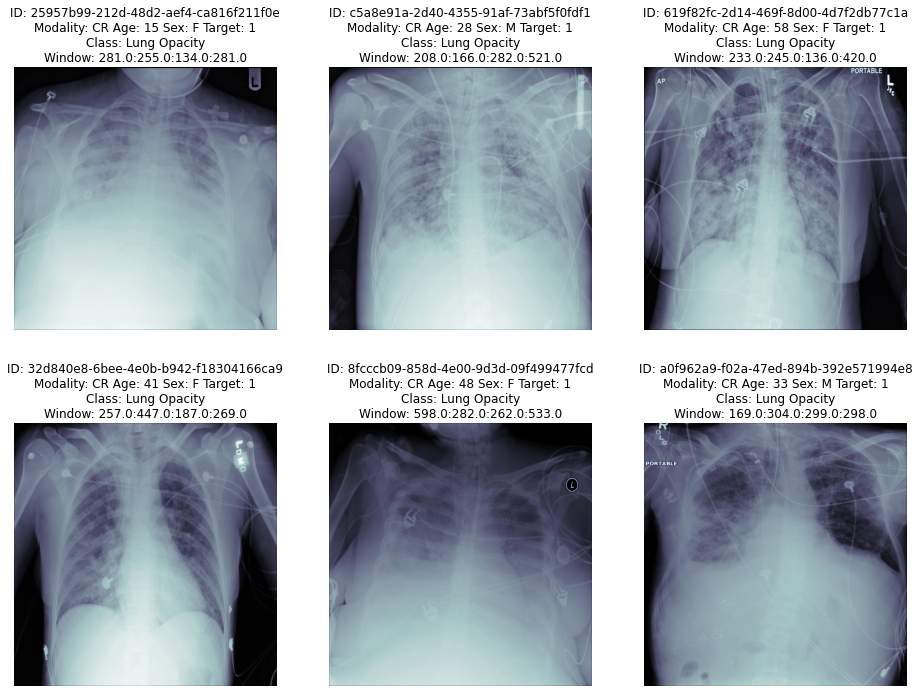

In [ ]:
images_present_df = df[df['image_exists']]
target1_sample = images_present_df[images_present_df['Target']==1].sample(6)

# alternatively if you didn't save data frame only containing present images
# you can use bitwise & operator on two boolean columns to select rows where Target is 1 and image_exists is 1

target1_sample = df[df['image_exists'] & (df['Target']==1)].sample(6)

plot_six_dicom_images(target1_sample)

We would like to represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with Target = 1 and gather all coordinates of the windows showing a Lung Opacity on the same image.


In [ ]:
from matplotlib.patches import Rectangle

def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(ROOT_PATH, 'train', patientImage)
        dcmdata = dcm.dcmread(imagePath)
        modality = dcmdata.Modality
        age = dcmdata.PatientAge
        sex = dcmdata.PatientSex
        ax[i//3, i%3].imshow(dcmdata.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = merged_df[merged_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()


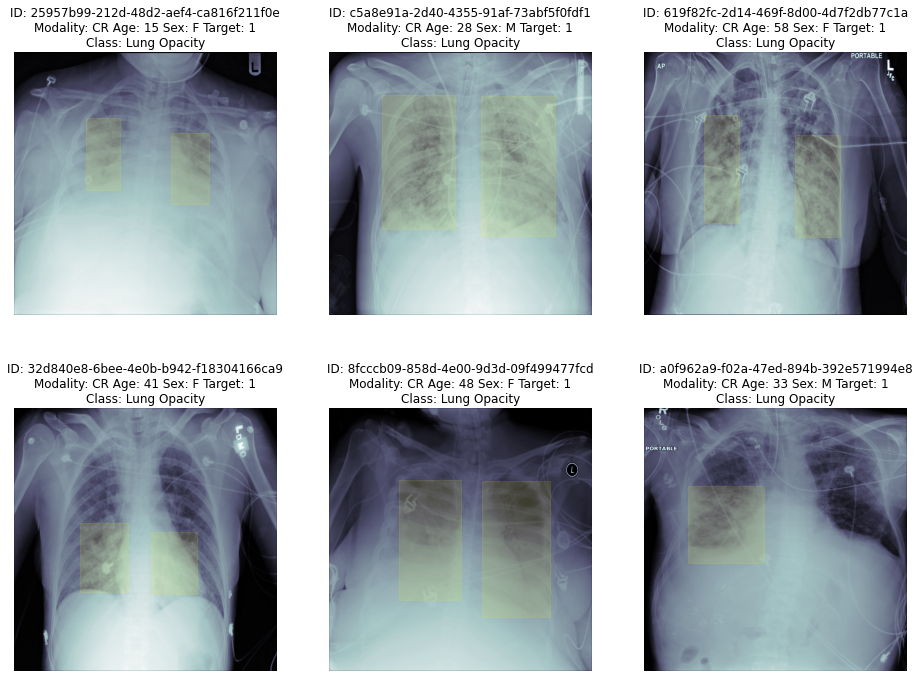

In [ ]:
show_dicom_images_with_boxes(target1_sample)

### Q16

In [ ]:
# Can you plot the patient case where there are 3 bounding boxes?

#### Q16 Answer

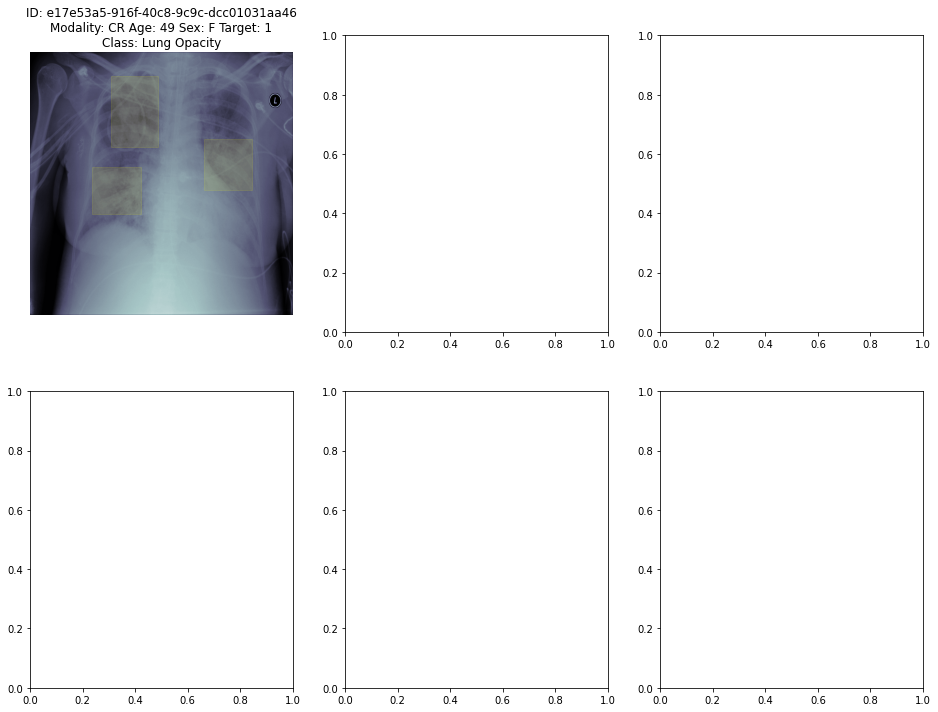

In [ ]:
show_dicom_images_with_boxes(right_df[right_df.image_exists].sample(1))


For some of the images with **Target=1**, we might see multiple areas (boxes/rectangles) with Lung Opacity.

Let's sample few images having the **Target = 0**.

## Plot DICOM images with Target = 0


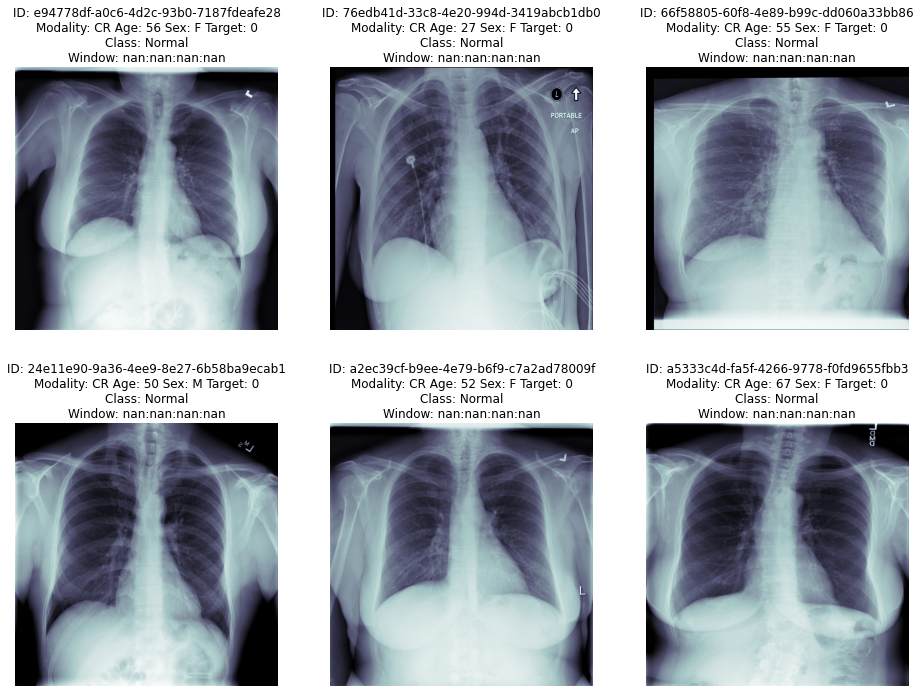

In [ ]:
## Normal images
target0_sample_normal = images_present_df[images_present_df['class']=='Normal'].drop_duplicates(subset='patientId').sample(6)
plot_six_dicom_images(target0_sample_normal)

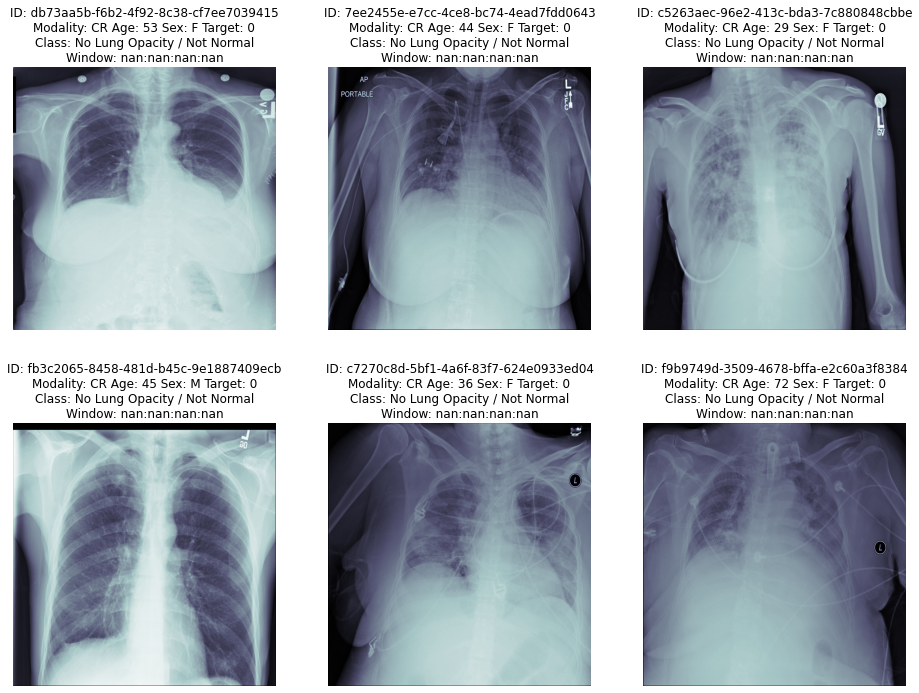

In [ ]:
## No Lung Opacity
target0_sample_abnormal = images_present_df[images_present_df['class']=='No Lung Opacity / Not Normal'].drop_duplicates(subset='patientId').sample(6)
plot_six_dicom_images(target0_sample_abnormal)

#Add meta information from DICOM files

##Train data

We will read the DICOM meta data from the dicome files and add it to the train dataset.

In [ ]:
dcmfields = ['PatientID', 'Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_image_dir(data_path):
    image_names = os.listdir(data_path)
    image_meta_data = []
    for i, img_name in enumerate(image_names):
        imagePath = os.path.join(data_path, img_name)
        dcmdata = dcm.dcmread(imagePath, stop_before_pixels=True)
        meta_data_row = [dcmdata.get(field) for field in dcmfields]
        image_meta_data.append(meta_data_row)
    return pd.DataFrame(image_meta_data, columns=dcmfields)

In [ ]:
dcm_metadata_df = process_dicom_image_dir(os.path.join(ROOT_PATH, 'train'))
dcm_metadata_df = dcm_metadata_df.rename(columns={'PatientID':'patientId'})
dcm_metadata_df

,patientId,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0a62df77-7459-4acc-9cca-a62c2cec4b0f,CR,45,F,CHEST,AP,WSD,1024,1024,"[0.168, 0.168]"
1,fe765ddd-3cee-49ef-8cec-d33accd7a5e5,CR,27,M,CHEST,AP,WSD,1024,1024,"[0.168, 0.168]"
2,3bb9b9b3-b086-4083-ae6f-d1f86c3eb089,CR,58,M,CHEST,AP,WSD,1024,1024,"[0.171, 0.171]"
3,b2fca33f-a7d4-4a8e-a6fe-2fcc48b7d1d9,CR,61,M,CHEST,PA,WSD,1024,1024,"[0.168, 0.168]"
4,ac7a86f8-447e-4062-9ed3-2361a6ea7fdc,CR,32,F,CHEST,PA,WSD,1024,1024,"[0.14300000000000002, 0.14300000000000002]"
...,...,...,...,...,...,...,...,...,...,...
295,f53a8cb7-7848-4589-8301-b5fcf6314ae4,CR,58,M,CHEST,PA,WSD,1024,1024,"[0.14300000000000002, 0.14300000000000002]"
296,7aec5115-877b-4315-8474-8c79a4389211,CR,73,F,CHEST,PA,WSD,1024,1024,"[0.14300000000000002, 0.14300000000000002]"
297,2055d3d1-e0d1-49a3-a416-2609e5c649bc,CR,64,M,CHEST,PA,WSD,1024,1024,"[0.14300000000000002, 0.14300000000000002]"
298,a515dbbc-e2f3-476a-a7f9-affa8720f176,CR,67,M,CHEST,PA,WSD,1024,1024,"[0.14300000000000002, 0.14300000000000002]"


In [ ]:
merged_df = df.merge(dcm_metadata_df, on='patientId', how='left')
merged_df[merged_df['image_exists']]

,patientId,x,y,width,height,Target,class,file_name,image_exists,NumRows,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
68,01e4fd43-4f2c-421f-bd68-c756dceb5742,NaN,NaN,NaN,NaN,0,Normal,01e4fd43-4f2c-421f-bd68-c756dceb5742.dcm,True,1,CR,62,M,CHEST,PA,WSD,1024.0,1024.0,"[0.14300000000000002, 0.14300000000000002]"
374,072e0dbf-11d7-4c57-8161-10c8e7b2f0bf,NaN,NaN,NaN,NaN,0,Normal,072e0dbf-11d7-4c57-8161-10c8e7b2f0bf.dcm,True,1,CR,12,M,CHEST,PA,WSD,1024.0,1024.0,"[0.14300000000000002, 0.14300000000000002]"
414,076149ed-e1a7-4424-b283-18161c95e0e2,NaN,NaN,NaN,NaN,0,Normal,076149ed-e1a7-4424-b283-18161c95e0e2.dcm,True,1,CR,48,F,CHEST,PA,WSD,1024.0,1024.0,"[0.14300000000000002, 0.14300000000000002]"
510,08307845-ccbd-4616-b8e9-58532a766dbe,217.0,566.0,214.0,232.0,1,Lung Opacity,08307845-ccbd-4616-b8e9-58532a766dbe.dcm,True,1,CR,56,M,CHEST,PA,WSD,1024.0,1024.0,"[0.168, 0.168]"
601,08ee8fda-45f1-4f46-a5ac-315a8d4dd196,645.0,534.0,279.0,274.0,1,Lung Opacity,08ee8fda-45f1-4f46-a5ac-315a8d4dd196.dcm,True,1,CR,59,F,CHEST,AP,WSD,1024.0,1024.0,"[0.168, 0.168]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29896,28eaff00-5fb7-40ee-8206-9d2ff5b081e0,NaN,NaN,NaN,NaN,0,Normal,28eaff00-5fb7-40ee-8206-9d2ff5b081e0.dcm,True,1,CR,48,M,CHEST,AP,WSD,1024.0,1024.0,"[0.139, 0.139]"
30002,2cc72d62-1144-4fe9-a4ab-da083ad11392,708.0,380.0,183.0,300.0,1,Lung Opacity,2cc72d62-1144-4fe9-a4ab-da083ad11392.dcm,True,2,CR,58,F,CHEST,AP,WSD,1024.0,1024.0,"[0.168, 0.168]"
30003,2cc72d62-1144-4fe9-a4ab-da083ad11392,371.0,404.0,177.0,283.0,1,Lung Opacity,2cc72d62-1144-4fe9-a4ab-da083ad11392.dcm,True,2,CR,58,F,CHEST,AP,WSD,1024.0,1024.0,"[0.168, 0.168]"
30064,2ee27b62-e1d7-4341-bf2b-9d45dc4068a1,NaN,NaN,NaN,NaN,0,Normal,2ee27b62-e1d7-4341-bf2b-9d45dc4068a1.dcm,True,1,CR,63,M,CHEST,PA,WSD,1024.0,1024.0,"[0.14300000000000002, 0.14300000000000002]"


## We only downloaded a subset of data

Using same function above we can read the metadata of all 26,684 training dicoms and 3000 test dicoms in 30 seconds of processing total.


In [ ]:
if use_full:
  import time
  a = time.time()
  dcm_train_metadata_full_df = process_dicom_image_dir('train/')
  dcm_test_metadata_full_df = process_dicom_image_dir('test/')
  b = time.time()
  print(b-a, 'seconds elapsed')
  dcm_train_metadata_full_df.to_csv('extras/dcm_train_metadata_full.csv', index=False)
  dcm_test_metadata_full_df.to_csv('extras/dcm_test_metadata_full.csv', index=False)
else:
  dcm_train_metadata_full_df = pd.read_csv('extras/dcm_train_metadata_full.csv')
  dcm_test_metadata_full_df = pd.read_csv('extras/dcm_test_metadata_full.csv')  

In [ ]:
merged_df = df.merge(dcm_train_metadata_full_df, on='patientId', how='left')


## Inspecting the DCM Data Fields

If we look at our full training data's dicom fields we see:

In [ ]:
merged_df[['Modality', 'BodyPartExamined', 'PatientSex', 'ViewPosition', 'ConversionType']].describe()

,Modality,BodyPartExamined,PatientSex,ViewPosition,ConversionType
count,30227,30227,30227,30227,30227
unique,1,1,2,2,1
top,CR,CHEST,M,AP,WSD
freq,30227,30227,17216,15297,30227


We see that **Modality**, **BodyPartExamined** and **ConversionType** all have exactly one value in all their cells (`unique=1`), hence all these images are modality `CR` (Computed Radiograph) that examined body part `CHEST`, with ConversionType WSD (Workstation).

We do have 2 unique values for PatientSex and ViewPosition



# **EXMAMINE THESE CHART RESULTS**

In [ ]:
merged_df[['PatientAge', 'Rows', 'Columns']].describe()

,PatientAge,Rows,Columns
count,30227.000000,30227.0,30227.0
mean,46.797764,1024.0,1024.0
std,16.892940,0.0,0.0
min,1.000000,1024.0,1024.0
25%,34.000000,1024.0,1024.0
50%,49.000000,1024.0,1024.0
75%,59.000000,1024.0,1024.0
max,155.000000,1024.0,1024.0


We also see for the numerical data of **Rows** and **Columns** that all the data is in a fixed shape with 1024 rows and 1024 columns.  These columns were inputed as numerical data, but we can note they are all identical by either noting that the **std** is 0 or that the **min** and **max** are both equal.

Meanwhile there's a wide array of **PatientAge** present including several data points that appear to be incorrect (PatientAge = 155)

## Inspecting View Position

We do observe that the ViewPosition changes between **PA** (posterior/anterior - with the patient facing away from the X-ray source) and AP (anteriorposterior - with the patient facing towards the X-ray source) in our dataset.

AP    7788
PA    1767
Name: ViewPosition, dtype: int64


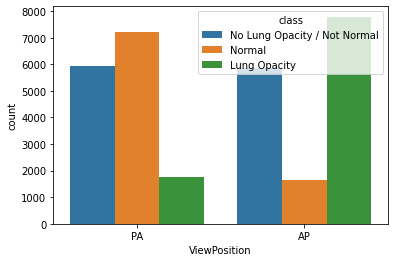

In [ ]:
ax=sns.countplot(data=merged_df, x='ViewPosition', hue='class')
print(merged_df[merged_df['Target'] == 1]['ViewPosition'].value_counts())

## Inspecting PatientSex



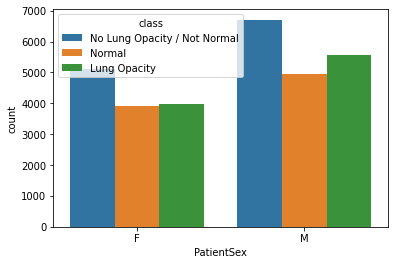

In [ ]:
ax=sns.countplot(data=merged_df, x='PatientSex', hue='class')

## Inspecting PatientAge



Incorrect ages (greater than 130): 5


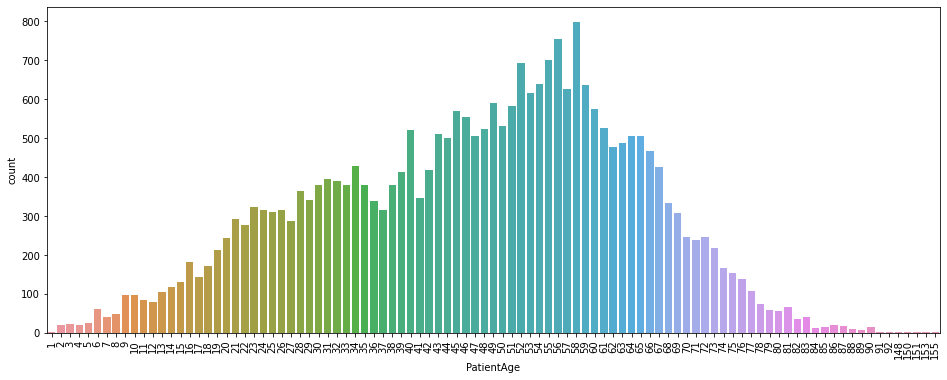

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
ax=sns.countplot(data=dcm_train_metadata_full_df, x='PatientAge')

print("Incorrect ages (greater than 130):", (dcm_train_metadata_full_df['PatientAge'] > 130).sum())

# Number of Target Cases plot by PatientSex

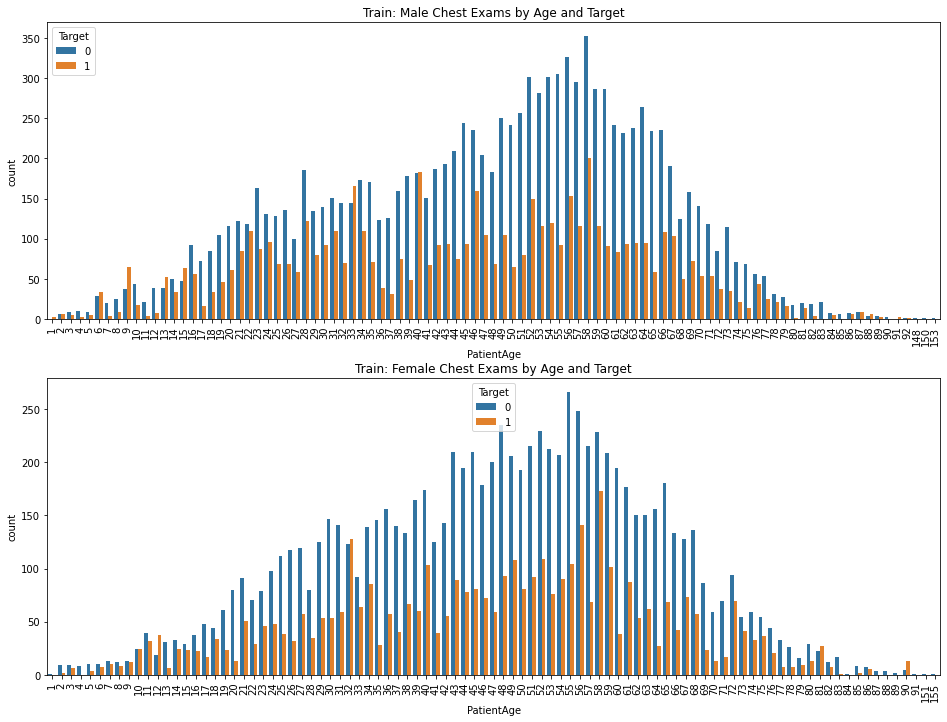

In [ ]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
plt.xticks(rotation=90)
ax2 = fig.add_subplot(212)
plt.xticks(rotation=90)
ax1.set_title("Train: Male Chest Exams by Age and Target")
ax1=sns.countplot(x='PatientAge', hue='Target', data=merged_df[merged_df['PatientSex']=='M'], ax=ax1)
ax2.set_title("Train: Female Chest Exams by Age and Target")
ax2=sns.countplot(x='PatientAge', hue='Target', data=merged_df[merged_df['PatientSex']=='F'], ax=ax2)


## Bounding Box Mask

To determine where to look for potential lung opacity, let's create a 1024x1024 box showing summing all the labeled bounding box regions in our training set.

`np.linspace(0, 1023, 1024)` create an numpy array `[0, 1, 2, ..., 1023]` with 1024 values.

`xx, yy = np.meshgrid(arr1, arr2)` creates two 2d-arrays (`xx`, `yy`) of the shape `len(arr1) x len(arr2)`. 

Every row of `xx` is a copy of `arr1` and there are `len(arr2)` copies present.

Every column of `yy` is a copy of `arr2` and there are `len(arr1)` copies present.



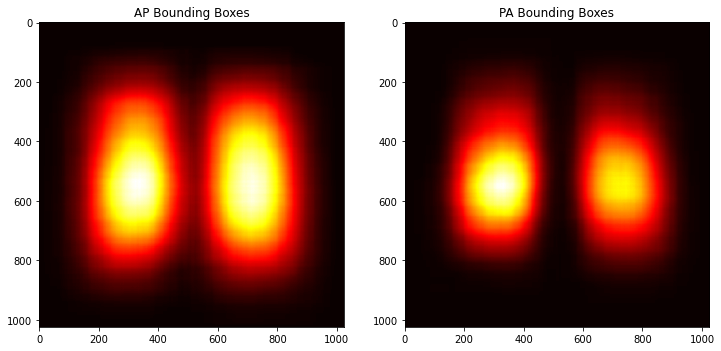

In [ ]:
xx, yy = np.meshgrid(np.linspace(0, 1023, 1024),
                     np.linspace(0, 1023, 1024), 
                     indexing='xy')
# xx is a 1024 x 1024 2d array where every row is [0, 1, 2, 3, ... ,1023]
# yy is a 1024 x 1024 2d array where the zeroth row is [0, 0, 0, ... ]
# the next row is [1, 1, 1, ...] ; i-th row is [i, i, i, ]

# in our example xx[i,j] will always be i and `yy[i,j]` will always be j
# so it makes it possible to quickly do vectorized math based on bounding box coordinates.


bboxes = {}
bboxes['AP'] = np.zeros_like(xx)
bboxes['PA'] = np.zeros_like(xx)
## Creates a zero filled array in same shape


for view in ('AP', 'PA'):
  for i, bbox in merged_df[(merged_df['Target']==1) & (merged_df['ViewPosition']==view)].sample(1767).iterrows():
      mask  = (xx >= bbox['x']) & (xx <= (bbox['x'] + bbox['width'] ))
      mask &= (yy >= bbox['y']) & (yy <= (bbox['y'] + bbox['height']))
      bboxes[view] += mask
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.set_title("AP Bounding Boxes")
subfig1 = ax1.imshow(bboxes['AP'], cmap='hot')

ax2.set_title("PA Bounding Boxes")
subfig2 = ax2.imshow(bboxes['PA'], cmap='hot')


## Overlay

We can then overlay this probability map over images from our training set.

In [ ]:
def show_dicom_images_with_bbox_dist(data, bboxes):    
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i, data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(ROOT_PATH, 'train', patientImage)
        dcmdata = dcm.dcmread(imagePath)
        modality = dcmdata.Modality
        age = dcmdata.PatientAge
        sex = dcmdata.PatientSex
        view = dcmdata.ViewPosition
        img = plt.cm.gray(dcmdata.pixel_array)
        img += 0.25*plt.cm.hot(bboxes[view]/bboxes[view].max())
        img = np.clip(img, 0, 1)

        ax[i//3, i%3].imshow(img) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nView: {}, Class: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], view, data_row['class']))
        rows = merged_df[merged_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())       
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="green", fill=False))   
    plt.show()


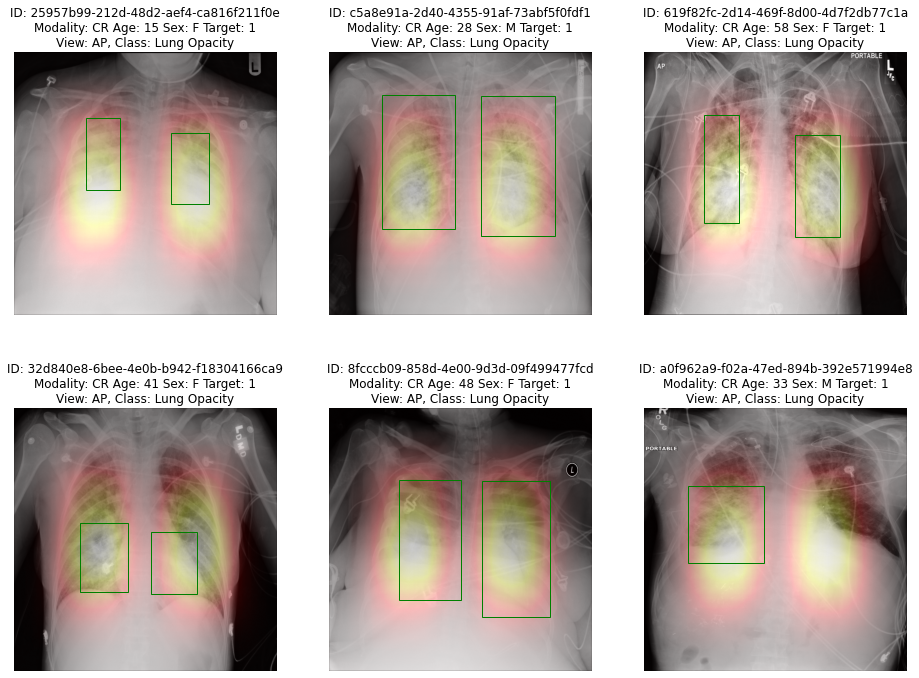

In [ ]:
show_dicom_images_with_bbox_dist(target1_sample, bboxes)